## ID: AI - 0016

## Submission Date: 16 January, 2018

## Abstract:
The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has recently released a dataset containing images of approximately 960 unique plants belonging to 12 species at several growth stages. 

If we can differentiate a weed from a crop seedling; the ability to do so effectively can mean better crop yields and better stewardship of the environment.

## Purpose of Assignment:
   1. Pre-processing the data
   2. Creative feature engineering and data augmentation
   3. Building a convolutional neural network 
   4. Tuning the hyper-parameters for better result
   5. Use transfer learning for even better results

## Details of Data:

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import mpl_toolkits.axes_grid1
from tqdm import tqdm
from glob import glob
import cv2
import os
import seaborn as sns
import os
import numpy as np
import pandas as pd
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16


In [1]:
species = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat',
           'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed',
           'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
num_species = len(species)

In [3]:
cw_dir = os.getcwd()
data_dir = 'C:/Users/Mahtab Noor Shaan/PycharmProjects/plant_seed_classification/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

for sp in species:
    print('{} images of {}'.format(len(os.listdir(os.path.join(train_dir, sp))),sp))

263 images of Black-grass
390 images of Charlock
287 images of Cleavers
611 images of Common Chickweed
221 images of Common wheat
475 images of Fat Hen
654 images of Loose Silky-bent
221 images of Maize
516 images of Scentless Mayweed
231 images of Shepherds Purse
496 images of Small-flowered Cranesbill
385 images of Sugar beet


As we can see, there is large skewness in training data. It will affect our model significantly

In [11]:
def read_image(filepath, target_size=None):
    img = cv2.imread(os.path.join(data_dir, filepath), cv2.IMREAD_COLOR)
    img = cv2.resize(img.copy(), target_size, interpolation = cv2.INTER_AREA)
    #img = image.load_img(os.path.join(data_dir, filepath),target_size=target_size)
    #img = image.img_to_array(img)
    return img

In [9]:
# read all train data
train = []
for species_id, sp in enumerate(species):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train.append(['train/{}/{}'.format(sp, file), file, species_id, sp])
train_df = pd.DataFrame(train, columns=['filepath', 'file', 'species_id', 'species'])
print('')
print('train_df.shape = ', train_df.shape)

# read all test data
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test_df = pd.DataFrame(test, columns=['filepath', 'file'])
print('test_df.shape = ', test_df.shape)



train_df.shape =  (4750, 4)
test_df.shape =  (794, 2)


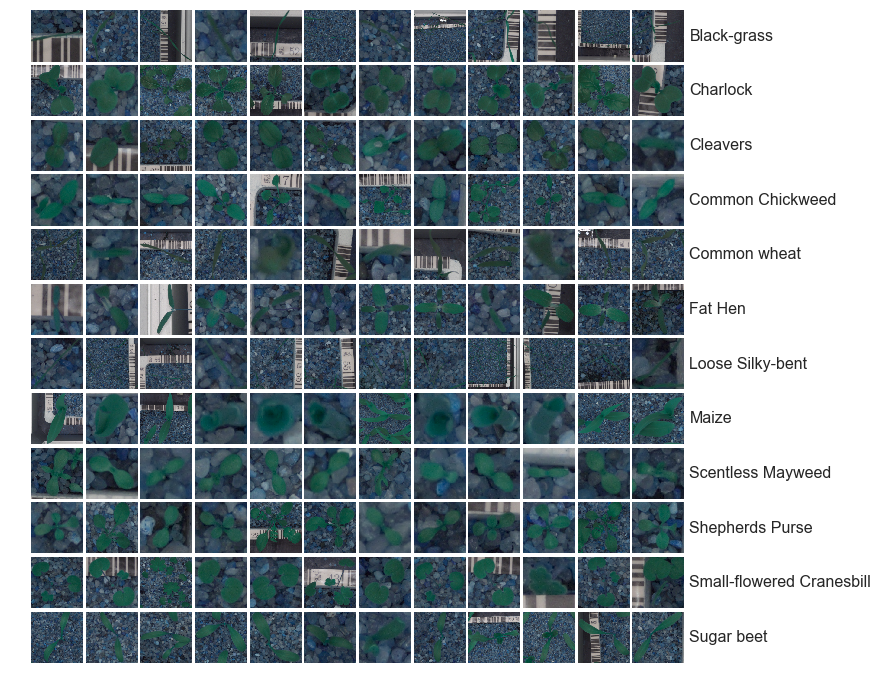

In [16]:
fig = plt.figure(1, figsize=(num_species, num_species))
grid = mpl_toolkits.axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_species, num_species), 
                                         axes_pad=0.05)
i = 0
for species_id, sp in enumerate(species):
    for filepath in train_df[train_df['species'] == sp]['filepath'].values[:num_species]:
        ax = grid[i]
        img = read_image(filepath, (224, 224))
        ax.imshow(img.astype(np.uint8))
        ax.axis('off')
        if i % num_species == num_species - 1:
            ax.text(250, 112, sp, verticalalignment='center')
        i += 1
plt.show()

Some images of the plant seeds from each categories are shown above

In [17]:
## detect and segment plants in the image 

def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

def read_segmented_image(filepath, img_size):
    img = cv2.imread(os.path.join(data_dir, filepath), cv2.IMREAD_COLOR)
    img = cv2.resize(img.copy(), img_size, interpolation = cv2.INTER_AREA)

    image_mask = create_mask_for_plant(img)
    image_segmented = segment_plant(img)
    image_sharpen = sharpen_image(image_segmented)
    return img, image_mask, image_segmented, image_sharpen

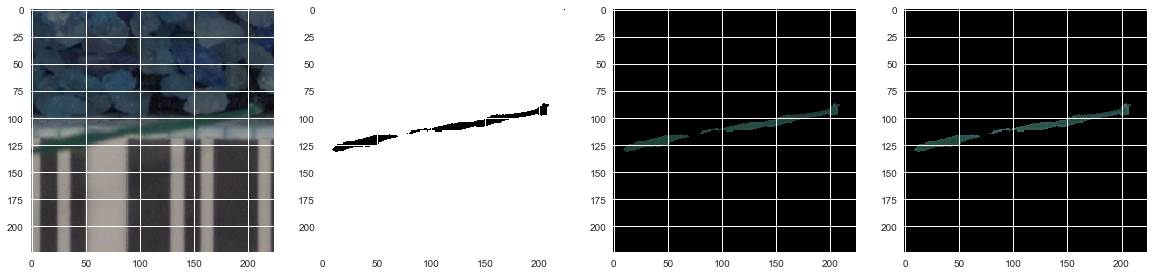

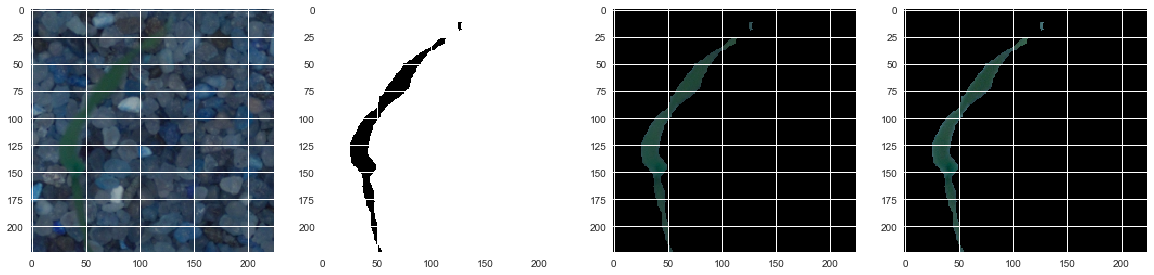

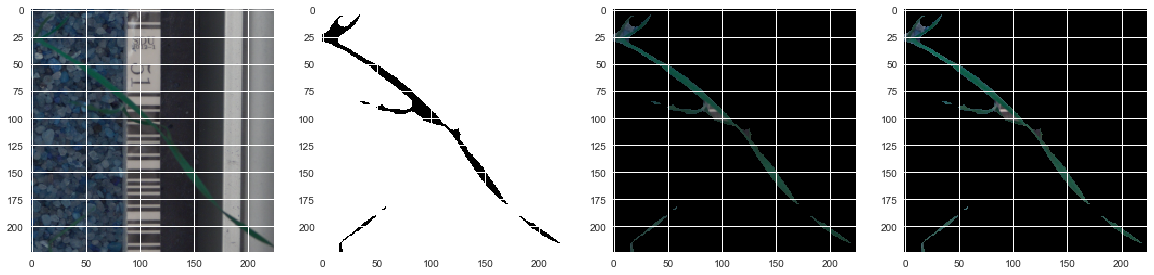

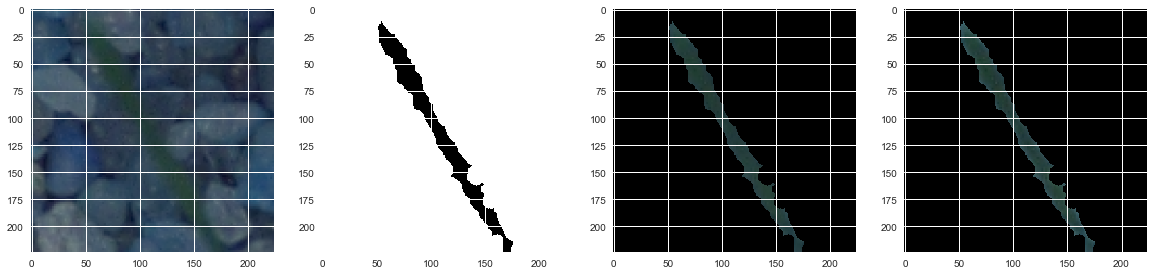

In [18]:
for i in range(4):
 
    img, image_mask, image_segmented, image_sharpen = read_segmented_image(
        train_df.loc[i,'filepath'],(224,224))

    fig, axs = plt.subplots(1, 4, figsize=(20, 20))
    axs[0].imshow(img.astype(np.uint8))
    axs[1].imshow(image_mask.astype(np.uint8))
    axs[2].imshow(image_segmented.astype(np.uint8))
    axs[3].imshow(image_sharpen.astype(np.uint8))
        

Each images were sagmented and preprocessed in different ways as shown in the figures above.

## Data Preparation:

### Splitting Train and Validation Sets:

In [ ]:
import numpy as np
import os
import shutil

def split_dataset_into_test_and_train_sets(all_data_dir, training_data_dir, testing_data_dir, testing_data_pct):
    # Recreate testing and training directories
    if testing_data_dir.count('/') > 1:
        shutil.rmtree(testing_data_dir, ignore_errors=False)
        os.makedirs(testing_data_dir)
        print("Successfully cleaned directory " + testing_data_dir)
    else:
        print("Refusing to delete testing data directory " + testing_data_dir)

    if training_data_dir.count('/') > 1:
        shutil.rmtree(training_data_dir, ignore_errors=False)
        os.makedirs(training_data_dir)
        print("Successfully cleaned directory " + training_data_dir)
    else:
        print("Refusing to delete testing data directory " + training_data_dir)

    num_training_files = 0
    num_testing_files = 0

    for subdir, dirs, files in os.walk(all_data_dir):
        category_name = os.path.basename(subdir)

        # Don't create a subdirectory for the root directory
        print(category_name + " vs " + os.path.basename(all_data_dir))
        if category_name == os.path.basename(all_data_dir):
            continue

        training_data_category_dir = training_data_dir + '/' + category_name
        testing_data_category_dir = testing_data_dir + '/' + category_name

        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)

        for file in files:
            input_file = os.path.join(subdir, file)
            if np.random.rand(1) < testing_data_pct:
                shutil.copy(input_file, testing_data_dir + '/' + category_name + '/' + file)
                num_testing_files += 1
            else:
                shutil.copy(input_file, training_data_dir + '/' + category_name + '/' + file)
                num_training_files += 1

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")

train_path = 'C:/Users/Mahtab Noor Shaan/PycharmProjects/plant_seed_classification/train/'
new_train_path = 'C:/Users/Mahtab Noor Shaan/PycharmProjects/plant_seed_classification/new_train/'
new_validation_path = 'C:/Users/Mahtab Noor Shaan/PycharmProjects/plant_seed_classification/new_validation/'

split_dataset_into_test_and_train_sets(train_path, new_train_path, new_validation_path, 0.2)

We created the validation set with 20% of the train data.

In [1]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

def load_dataset(path):
    data = load_files(path)
    plant_files = np.array(data['filenames'])
    plant_targets = np_utils.to_categorical(np.array(data['target']), 12)
    return plant_files, plant_targets

train_files, train_targets = load_dataset('C:/Users/Mahtab Noor Shaan/PycharmProjects/plant_seed_classification/new_train')
valid_files, valid_targets = load_dataset('C:/Users/Mahtab Noor Shaan/PycharmProjects/plant_seed_classification/new_validation')
#test_files, test_targets = load_dataset('C:/Users/Mahtab Noor Shaan/PycharmProjects/dog_breed_recognition/test')

plant_names = [item[20:-1] for item in sorted(glob("C:/Users/Mahtab Noor Shaan/PycharmProjects/plant_seed_classification/new_train/*/"))]

# Let's check the dataset
print('There are %d total plant categories.' % len(plant_names))
print('There are %s total plant images.\n' % len(np.hstack([train_files, valid_files])))
print('There are %d training plant images.' % len(train_files))
print('There are %d validation plant images.' % len(valid_files))

Using TensorFlow backend.


There are 12 total plant categories.
There are 4750 total plant images.

There are 3772 training plant images.
There are 978 validation plant images.


In [3]:
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

This is the function used to create train, validation and test tensors which are used in both CNN from scratch as input and for creating bottleneck features using different transfer learning methods.

In [4]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
train_tensors = paths_to_tensor(train_files).astype('float32')/255

100%|██████████| 3772/3772 [00:53<00:00, 70.57it/s]


In [6]:
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255

100%|██████████| 978/978 [00:14<00:00, 67.35it/s]


In [7]:
import glob

files = glob.glob('C:/Users/Mahtab Noor Shaan/PycharmProjects/plant_seed_classification/test/*.png')
test_tensors = paths_to_tensor(files).astype('float32')/255

100%|██████████| 794/794 [00:05<00:00, 136.39it/s]


## CNN from Scratch:

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

In [11]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(12, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
__________

The model summary for the Convolutional Neural Network(CNN) I used for this problem is shown above. The model design was selected after different tries and hyper parameter tuning.

In [12]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
from keras.callbacks import ModelCheckpoint  
epochs = 10

checkpointer = ModelCheckpoint(filepath='weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=2)

Train on 3772 samples, validate on 978 samples
Epoch 1/10
Epoch 00001: val_loss improved from inf to 1.44866, saving model to weights.best.from_scratch.hdf5
 - 80s - loss: 1.8070 - acc: 0.4040 - val_loss: 1.4487 - val_acc: 0.5123
Epoch 2/10
Epoch 00002: val_loss improved from 1.44866 to 1.00955, saving model to weights.best.from_scratch.hdf5
 - 69s - loss: 1.1779 - acc: 0.6047 - val_loss: 1.0096 - val_acc: 0.6687
Epoch 3/10
Epoch 00003: val_loss improved from 1.00955 to 0.89689, saving model to weights.best.from_scratch.hdf5
 - 70s - loss: 0.9007 - acc: 0.6954 - val_loss: 0.8969 - val_acc: 0.7025
Epoch 4/10
Epoch 00004: val_loss improved from 0.89689 to 0.76902, saving model to weights.best.from_scratch.hdf5
 - 68s - loss: 0.6663 - acc: 0.7789 - val_loss: 0.7690 - val_acc: 0.7413
Epoch 5/10
Epoch 00005: val_loss improved from 0.76902 to 0.64807, saving model to weights.best.from_scratch.hdf5
 - 68s - loss: 0.4681 - acc: 0.8454 - val_loss: 0.6481 - val_acc: 0.7935
Epoch 6/10
Epoch 00006

As we can see, our model started to overfit after 5 epochs. But we saved the weights for the best result and use it for prediction.

In [14]:
model.load_weights('weights.best.from_scratch.hdf5')
predicted = model.predict(test_tensors)

In [15]:
predicted.shape

(794, 12)

In [16]:
label_map = {   "Black-grass"               :0,
                "Charlock"                  :1,
                "Cleavers"                  :2,
                "Common Chickweed"          :3,
                "Common wheat"              :4,
                "Fat Hen"                   :5,
                "Loose Silky-bent"          :6,
                "Maize"                     :7,
                "Scentless Mayweed"         :8,
                "Shepherds Purse"           :9,
                "Small-flowered Cranesbill" :10,
                "Sugar beet"                :11}

In [ ]:
import pandas as pd
df_test = pd.read_csv('sample_submission.csv')

In [ ]:
preds = []
for i in range(len(predicted)):
    pos = np.argmax(predicted[i])
    preds.append(list(label_map.keys())[list(label_map.values()).index(pos)])
    
df_test['species'] = preds
df_test.to_csv('submission_scratch.csv', index=False)

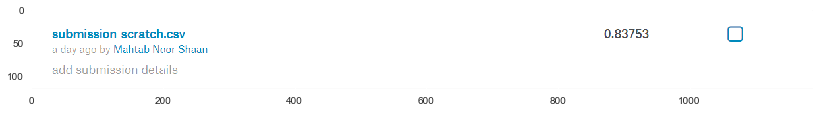

In [21]:
plt.figure(figsize=(14,10))
img=mpimg.imread('scratch.png')
imgplot = plt.imshow(img)
plt.show()

## Transfer Learning(Xception Model):

In [3]:
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications import *

In [4]:
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False)

In [ ]:
train_x_bf = xception_bottleneck.predict(train_tensors, batch_size=6, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
np.save(open('train_x_bf_full_xception.npy', 'wb'), train_x_bf)

In [ ]:
valid_x_bf = xception_bottleneck.predict(valid_tensors, batch_size=6, verbose=1)
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))
np.save(open('valid_x_bf_full_xception.npy', 'wb'), valid_x_bf)

In [ ]:
test_x_bf = xception_bottleneck.predict(test_tensors, batch_size=6, verbose=1)
print('Xception test bottleneck features shape: {} size: {:,}'.format(test_x_bf.shape, test_x_bf.size))
np.save(open('test_x_bf_full_xception.npy', 'wb'), test_x_bf)

In [5]:
import numpy as np
train_x_bf = np.load(open('train_x_bf_full_xception256.npy', 'rb'))
valid_x_bf = np.load(open('valid_x_bf_full_xception256.npy', 'rb'))
test_x_bf = np.load(open('test_x_bf_full_xception256.npy', 'rb'))

We use Xception model for transfer learning. Here, we only take the bottleneck features for train, validation and test set and use them as input of a 2 layer neural network for solving this problem. We didn't have much processing power, so we did not go for training layers in the convolutional network, which could have produced even better result.

In [ ]:
datagen = ImageDataGenerator( horizontal_flip=True, 
                              vertical_flip=True)

In [7]:
epochs = 100
learning_rate = 0.0001
batch_size = 32

callbacks = [ EarlyStopping(monitor='val_loss', patience=5, verbose=0), 
              ModelCheckpoint(filepath='weights.best.xception.hdf5', monitor='val_loss', save_best_only=True, verbose=0),
              ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)]

In [8]:
model = Sequential()
model.add(Flatten(input_shape=train_x_bf.shape[1:]))
model.add(Dense(256, activation='relu', ))
model.add(BatchNormalization())
model.add(Dropout(0.8))
model.add(Dense(12, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33554688  
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                3084      
Total params: 33,558,796
Trainable params: 33,558,284
Non-trainable params: 512
_________________________________________________________________


In [9]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=learning_rate), metrics=['accuracy'])

In [10]:
history = model.fit_generator(datagen.flow(train_x_bf, train_targets, batch_size=batch_size),
                    steps_per_epoch=len(train_x_bf)/batch_size, 
                    validation_data=datagen.flow(valid_x_bf, valid_targets, batch_size=batch_size), 
                    validation_steps=len(valid_x_bf)/batch_size,
                    callbacks=callbacks,
                    epochs=epochs, 
                    verbose=2)

C:\Users\Mahtab Noor Shaan\Anaconda3\lib\site-packages\keras\preprocessing\image.py:855: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (3772, 8, 8, 2048) (2048 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')
C:\Users\Mahtab Noor Shaan\Anaconda3\lib\site-packages\keras\preprocessing\image.py:855: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (978, 8, 8, 2048) (2048 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/100
 - 45s - loss: 2.4102 - acc: 0.3836 - val_loss: 1.1428 - val_acc: 0.6288
Epoch 2/100
 - 38s - loss: 1.5046 - acc: 0.5644 - val_loss: 0.8971 - val_acc: 0.7352
Epoch 3/100
 - 36s - loss: 1.2329 - acc: 0.6284 - val_loss: 0.7593 - val_acc: 0.7607
Epoch 4/100
 - 37s - loss: 1.0621 - acc: 0.6857 - val_loss: 0.6944 - val_acc: 0.7740
Epoch 5/100
 - 34s - loss: 0.9669 - acc: 0.6923 - val_loss: 0.6685 - val_acc: 0.7802
Epoch 6/100
 - 31s - loss: 0.8616 - acc: 0.7296 - val_loss: 0.7144 - val_acc: 0.7751
Epoch 7/100
 - 34s - loss: 0.8076 - acc: 0.7434 - val_loss: 0.6315 - val_acc: 0.8037
Epoch 8/100
 - 35s - loss: 0.7144 - acc: 0.7782 - val_loss: 0.6123 - val_acc: 0.8098
Epoch 9/100
 - 34s - loss: 0.6825 - acc: 0.7738 - val_loss: 0.6100 - val_acc: 0.8098
Epoch 10/100
 - 34s - loss: 0.6529 - acc: 0.7906 - val_loss: 0.5607 - val_acc: 0.8211
Epoch 11/100
 - 31s - loss: 0.6236 - acc: 0.8080 - val_loss: 0.5655 - val_acc: 0.8139
Epoch 12/100
 - 35s - loss: 0.5950 - acc: 0.8026 - val_loss: 0.

In [11]:
model.load_weights('weights.best.xception.hdf5')
predicted = model.predict(test_x_bf)

In [12]:
predicted.shape

(794, 12)

In [13]:
label_map = {   "Black-grass"               :0,
                "Charlock"                  :1,
                "Cleavers"                  :2,
                "Common Chickweed"          :3,
                "Common wheat"              :4,
                "Fat Hen"                   :5,
                "Loose Silky-bent"          :6,
                "Maize"                     :7,
                "Scentless Mayweed"         :8,
                "Shepherds Purse"           :9,
                "Small-flowered Cranesbill" :10,
                "Sugar beet"                :11}

In [14]:
import pandas as pd
df_test = pd.read_csv('sample_submission.csv')

In [15]:
preds = []
for i in range(len(predicted)):
    pos = np.argmax(predicted[i])
    preds.append(list(label_map.keys())[list(label_map.values()).index(pos)])
    
df_test['species'] = preds
df_test.to_csv('submission_xception.csv', index=False)

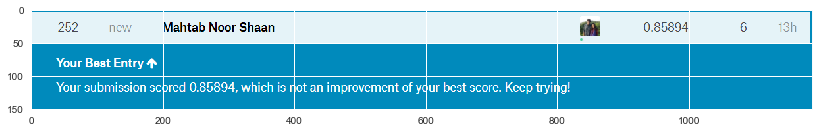

In [19]:
plt.figure(figsize=(14,10))
img=mpimg.imread('Xception.png')
imgplot = plt.imshow(img)
plt.show()

## Logreg and SVM:

We also used the bottleneck features we got from the Xception model as input in a model performing Logistic Regression and another with Support Vector Machine(SVM) for comparison. The model with Logistic Regression performed reasonably well with 83.9% validation accuracy.

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
NUM_CLASSES = 12

In [3]:
import numpy as np
train_x_bf = np.load(open('train_x_bf_fullavg_xception256.npy', 'rb'))
valid_x_bf = np.load(open('valid_x_bf_fullavg_xception256.npy', 'rb'))
test_x_bf = np.load(open('test_x_bf_fullavg_xception256.npy', 'rb'))

In [4]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
logreg.fit(train_x_bf, (train_targets * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)
print('Validation Xception LogLoss {}'.format(log_loss(valid_targets, valid_probs)))
print('Validation Xception Accuracy {}'.format(accuracy_score((valid_targets * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Validation Xception LogLoss 0.508464418536276
Validation Xception Accuracy 0.8394683026584867


In [5]:
from sklearn import svm

In [6]:
svm = svm.SVC()
svm.fit(train_x_bf, (train_targets * range(NUM_CLASSES)).sum(axis=1))
#valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = svm.predict(valid_x_bf)
#print('Validation Xception LogLoss {}'.format(log_loss(valid_targets, valid_probs)))
print('Validation Xception Accuracy {}'.format(accuracy_score((valid_targets * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Validation Xception Accuracy 0.5777096114519428


## Discussion:

We achieved 85% accuracy in test images with transfer learning method. We could have performed even better if we could implement training deeper layers too; which was not possible due to less processing power.

Also, without transfer learning we achieved 79% validation accuracy. With more careful model design and hyper parameter tuning, we could have performed better. But this process is very time consuming.

Also, simple machine learning algorithms like logistic regression and SVM provided better results too.